In [2]:
# import astropy
import numpy as np
import matplotlib.pyplot as plt
# from astropy.coordinates import get_body
# from astropy.time import Time


In [3]:
from astropy.coordinates import get_body, EarthLocation, AltAz
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris
import astropy.units as u

solar_system_ephemeris.set('de432s')


<ScienceState solar_system_ephemeris: 'de432s'>

In [4]:
times = Time('2024-01-01 00:00:00') + np.arange(0, 365, 1) * u.day
location = EarthLocation(lat=40.7128*u.deg, lon=-74.0060*u.deg, height=0*u.m)


In [5]:
jupiter_positions = get_body('jupiter', times, location)


In [6]:
ra = jupiter_positions.ra.deg
dec = jupiter_positions.dec.deg
distance = jupiter_positions.distance.au


In [7]:
distance.shape

(365,)

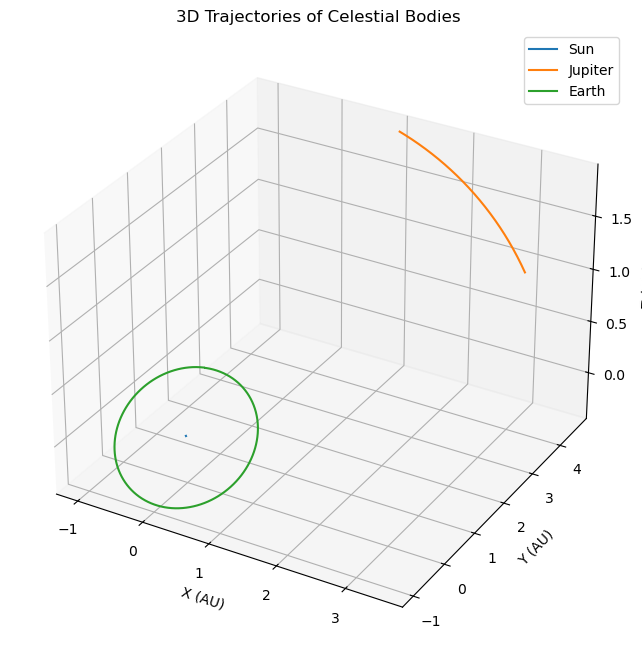

In [8]:
from astropy.coordinates import get_body_barycentric, solar_system_ephemeris
from astropy.time import Time
import astropy.units as u
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots

'''
An ephemeris is a tabulated set of data that provides the positions
and velocities of celestial bodies, such as planets, comets, and satellites,
at specific times.
'''
# Set the ephemeris
solar_system_ephemeris.set('de432s')

times = Time('2024-01-01 00:00:00') + np.arange(0, 365, 1) * u.day  # time range
bodies = ['sun', 'jupiter', 'earth']  # bodies to track
positions = {body: np.array([get_body_barycentric(body, time).xyz.to(u.au).value for time in times]) 
             for body in bodies}  # (3d) positions of the bodies (wrt to solar system barycentre)

# Plot trajectories of bodies
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for body, coords in positions.items():
    x, y, z = coords.T
    ax.plot(x, y, z, label=body.capitalize())
ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.legend()
ax.set_title("3D Trajectories of Celestial Bodies")
plt.show()

In [9]:
velocities = {
    body: np.gradient(positions[body], axis=0) / (1 * u.day).to(u.s).value for body in positions
}  # (3d) velovities estimation of the chosen bodies in 

# print(velocities[:10])
# print(type(velocities))
# print(velocities)


Using astroquery to query data from JPL Horizons: high-accuracy time-series data, including positions and velocities.


In [10]:

'''

---- Obtaining IDs ----
If you need to verify these IDs or find IDs for other objects, you can:
Use the Horizons web interface and search for the object name.
Utilise the Horizons Lookup API to retrieve object information.
Use the astroquery library in Python, which provides a convenient interface to JPL Horizons.
For example, using the Horizons Lookup API:
https://ssd.jpl.nasa.gov/api/horizons_lookup.api?sstr=saturn

The solar system barycentre is 0: {"spkid":"0","name":"Solar System Barycenter","pdes":null,"alias":["SSB"]}

---- Regarding planet's "barycentre" ----
The planet is the object, and the barycentre is the weighted centre of mass of the planet and everything that orbits it (eg moons).


https://ssd.jpl.nasa.gov/api/horizons_lookup.api?sstr=barycenter:

{"signature":{"source":"NASA/JPL Horizons Lookup API","version":"1.0"},
 "count":10,"result":[{"spkid":"0","name":"Solar System Barycenter","pdes":null,"alias":["SSB"]},
                      {"pdes":null,"spkid":"1","name":"Mercury Barycenter","alias":[]},
                      {"name":"Venus Barycenter","spkid":"2","pdes":null,"alias":[]},
                      {"alias":["EMB"],"pdes":null,"name":"Earth-Moon Barycenter","spkid":"3"},
                      {"alias":[],"name":"Mars Barycenter","spkid":"4","pdes":null},
                      {"alias":[],"spkid":"5","name":"Jupiter Barycenter","pdes":null},
                      {"alias":[],"name":"Saturn Barycenter","spkid":"6","pdes":null},
                      {"spkid":"7","name":"Uranus Barycenter","pdes":null,"alias":[]},
                      {"name":"Neptune Barycenter","spkid":"8","pdes":null,"alias":[]},
                      {"pdes":null,"name":"Pluto Barycenter","spkid":"9","alias":[]}]}
'''

'\n\n---- Obtaining IDs ----\nIf you need to verify these IDs or find IDs for other objects, you can:\nUse the Horizons web interface and search for the object name.\nUtilise the Horizons Lookup API to retrieve object information.\nUse the astroquery library in Python, which provides a convenient interface to JPL Horizons.\nFor example, using the Horizons Lookup API:\nhttps://ssd.jpl.nasa.gov/api/horizons_lookup.api?sstr=saturn\n\nThe solar system barycentre is 0: {"spkid":"0","name":"Solar System Barycenter","pdes":null,"alias":["SSB"]}\n\n---- Regarding planet\'s "barycentre" ----\nThe planet is the object, and the barycentre is the weighted centre of mass of the planet and everything that orbits it (eg moons).\n\n\nhttps://ssd.jpl.nasa.gov/api/horizons_lookup.api?sstr=barycenter:\n\n{"signature":{"source":"NASA/JPL Horizons Lookup API","version":"1.0"},\n "count":10,"result":[{"spkid":"0","name":"Solar System Barycenter","pdes":null,"alias":["SSB"]},\n                      {"pdes":n

In [11]:
def spherical_to_cartesian(RA, DEC, r):
    """
    Convert spherical coordinates (RA, DEC, r) to Cartesian coordinates (x, y, z).
    parameters:
    RA (array-like): right Ascension in radians
    DEC (array-like): declination in radians
    r (array-like): radial distance (distance from observer/sun)
    returns:
    tuple: cartesian coordinates (x, y, z).
    """
    x = r * np.cos(DEC) * np.cos(RA)
    y = r * np.cos(DEC) * np.sin(RA)
    z = r * np.sin(DEC)
    return x, y, z

# Convert to cartesian coordinates
# x, y, z = spherical_to_cartesian(RA, DEC, r)
# vx, vy, vz = np.gradient([x, y, z], axis=0)


In [12]:
from astroquery.jplhorizons import Horizons

bodies_names = ['Jupiter', 'Sun', 'Earth', 'Saturn']   # bodies to track
bodies = ['599', '10', '399', '699']   # bodies to track

# Query from ephemeris
trajectories = {}
for body in bodies:
    obj = Horizons(id=body, location='@0',
                   epochs={'start': '2024-01-01', 'stop': '2024-12-31', 'step': '1d'})
    # eph = obj.ephemerides()
    # print(eph.columns)  # column names
    # trajectories[body] = {
    #     'x': eph['x'], 'y': eph['y'], 'z': eph['z'],
    #     'vx': eph['vx'], 'vy': eph['vy'], 'vz': eph['vz']
    # }
    # trajectories[body] = {
    #     'RA': eph['RA'],                  # right Ascension
    #     'DEC': eph['DEC'],                # declination
    #     'r': eph['r'],                    # radial distance
    #     'r_rate': eph['r_rate'],          # radial velocity (change in r)
    #     'delta': eph['delta'],            # distance to the target
    #     'delta_rate': eph['delta_rate'],  # rate of change of distance
    #     # 'vel_sun': eph['vel_sun'],        # velocity relative to the sun
    #     # 'vel_obs': eph['vel_obs'],        # velocity relative to the observer
    # }

    vecs = obj.vectors()
    trajectories[body] = {
        'x': vecs['x'], 'y': vecs['y'], 'z': vecs['z'],
        'vx': vecs['vx'], 'vy': vecs['vy'], 'vz': vecs['vz']
    }    


ModuleNotFoundError: No module named 'astroquery'

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot bodies
for (body, data), body_name in zip(trajectories.items(), bodies_names):
    # print(body_name)
    ax.plot(data['x'], data['y'], data['z'], label=body_name)
ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_title('trajectories of celestial bodies')
ax.legend()

plt.show()



Data retrieved for body: 599
Data retrieved for body: 10
Data retrieved for body: 399
Data retrieved for body: 699
Data successfully saved to c:\Users\harmi\UCL\Year2\Term1\Modelling_and_simulation\Coursework\three_bodies\celestial_data.hdf5


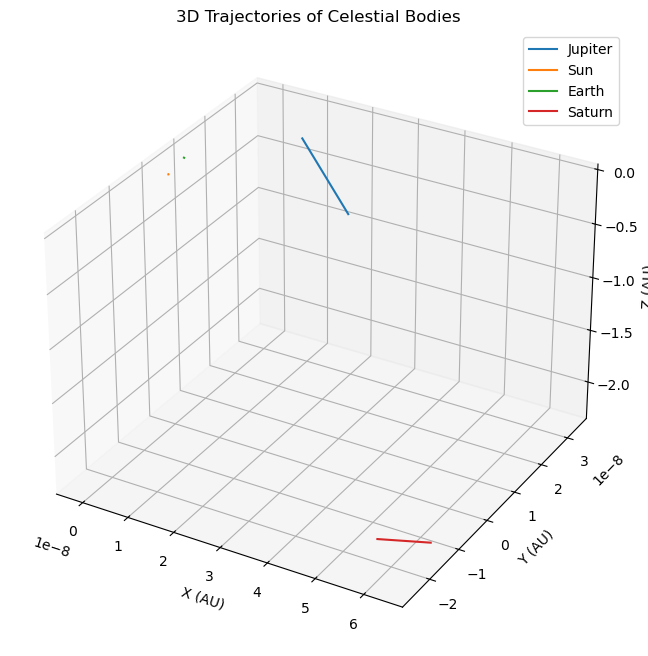

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from scipy.constants import G
import os

# Constants
AU = 1.496e11  # Astronomical Unit in meters
Msun = 1.989e30  # Mass of the Sun in kg

# Function to calculate kinetic energy
def kinetic_energy(mass, velocity):
    return 0.5 * mass * np.linalg.norm(velocity, axis=0)**2

# Function to calculate gravitational potential energy between two bodies
def gravitational_potential_energy(m1, m2, r):
    return -G * m1 * m2 / r

# Function to calculate angular momentum
def angular_momentum(position, velocity, mass):
    return np.cross(position.T, mass * velocity.T).T

# Function to extract the positions and velocities of the bodies from JPL Horizons
def get_positions_and_velocities(bodies, start_date, end_date):
    trajectories = {}
    time_range = Time([start_date, end_date], format='iso')
    
    for body in bodies:
        try:
            obj = Horizons(id=body, location='@0', epochs=time_range.jd)
            vectors = obj.vectors()
            trajectories[body] = {
                'x': vectors['x'].data * 1e3,  # Convert from km to m
                'y': vectors['y'].data * 1e3,
                'z': vectors['z'].data * 1e3,
                'vx': vectors['vx'].data * 1e3,  # Convert from km/s to m/s
                'vy': vectors['vy'].data * 1e3,
                'vz': vectors['vz'].data * 1e3,
            }
            print(f"Data retrieved for body: {body}")
        except Exception as e:
            print(f"Failed to retrieve data for body {body}: {e}")

    return trajectories, time_range


# List of bodies and their IDs in JPL Horizons
bodies = ['599', '10', '399', '699']  # Jupiter, Sun, Earth, Saturn
bodies_names = ['Jupiter', 'Sun', 'Earth', 'Saturn']

# Get positions and velocities for the bodies
start_date = '2024-01-01'
end_date = '2024-12-31'
trajectories, times = get_positions_and_velocities(bodies, start_date, end_date)

# Map trajectories to human-readable body names
data = {
    bodies_names[i]: pd.DataFrame(trajectories[bodies[i]]) for i in range(len(bodies))
}

# Example: Calculate the distance between Earth and Jupiter
earth_position = np.array([data['Earth']['x'], data['Earth']['y'], data['Earth']['z']])
jupiter_position = np.array([data['Jupiter']['x'], data['Jupiter']['y'], data['Jupiter']['z']])
distances_earth_jupiter = np.linalg.norm(earth_position - jupiter_position, axis=0)

# Example: Calculate energies for each body
masses = {'Jupiter': 1.898e27, 'Sun': 1.989e30, 'Earth': 5.972e24, 'Saturn': 5.683e26}
energies = {}
for body in bodies_names:
    position = np.array([data[body]['x'], data[body]['y'], data[body]['z']])
    velocity = np.array([data[body]['vx'], data[body]['vy'], data[body]['vz']])
    mass = masses[body]

    # Kinetic Energy
    ke = kinetic_energy(mass, velocity)

    # Potential Energy
    pe = np.sum([
        gravitational_potential_energy(
            mass, 
            masses[other_body], 
            np.linalg.norm(position - np.array([data[other_body]['x'], data[other_body]['y'], data[other_body]['z']]), axis=0)
        )
        for other_body in bodies_names if other_body != body
    ])

    energies[body] = {
        'Kinetic Energy': ke,
        'Potential Energy': pe,
        'Total Energy': ke + pe,
    }

# Example: Calculate angular momentum for each body
angular_momenta = {}
for body in bodies_names:
    position = np.array([data[body]['x'], data[body]['y'], data[body]['z']])
    velocity = np.array([data[body]['vx'], data[body]['vy'], data[body]['vz']])
    mass = masses[body]
    am = angular_momentum(position, velocity, mass)
    angular_momenta[body] = np.linalg.norm(am, axis=0)  # Get the magnitude

# Save data to HDF5
hdf5_file = 'celestial_data.hdf5'
with pd.HDFStore(hdf5_file, mode='w') as store:
    for body in bodies_names:
        store.put(f'{body}/trajectory', data[body], format='table')
        energies_df = pd.DataFrame(energies[body])
        store.put(f'{body}/energies', energies_df, format='table')
        angular_momentum_df = pd.DataFrame({'Angular Momentum': angular_momenta[body]})
        store.put(f'{body}/angular_momentum', angular_momentum_df, format='table')

print(f"Data successfully saved to {os.path.abspath(hdf5_file)}")

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for body in bodies_names:
    ax.plot(
        data[body]['x'] / AU, 
        data[body]['y'] / AU, 
        data[body]['z'] / AU, 
        label=body
    )
ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_title('3D Trajectories of Celestial Bodies')
ax.legend()
plt.show()
